# ORIE 4741 Project
### Netflix Success Predictor

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [82]:
netflix=pd.read_csv('datasets/netflix.csv')

In [83]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with NaN values: 

In [84]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


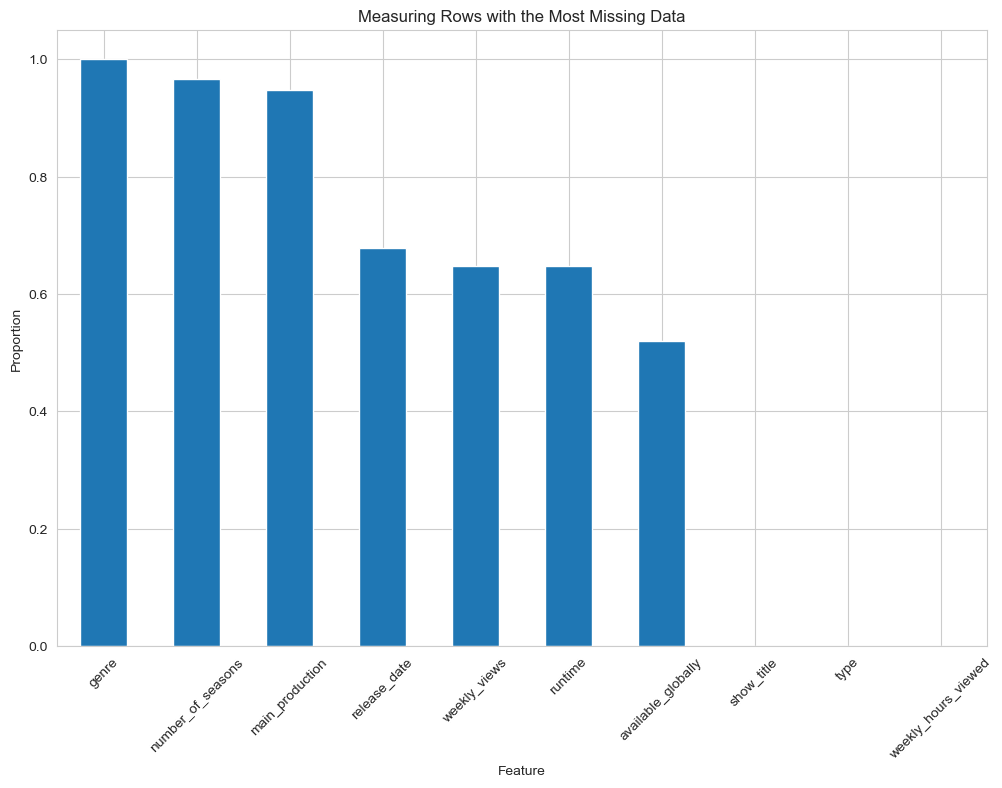

In [85]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


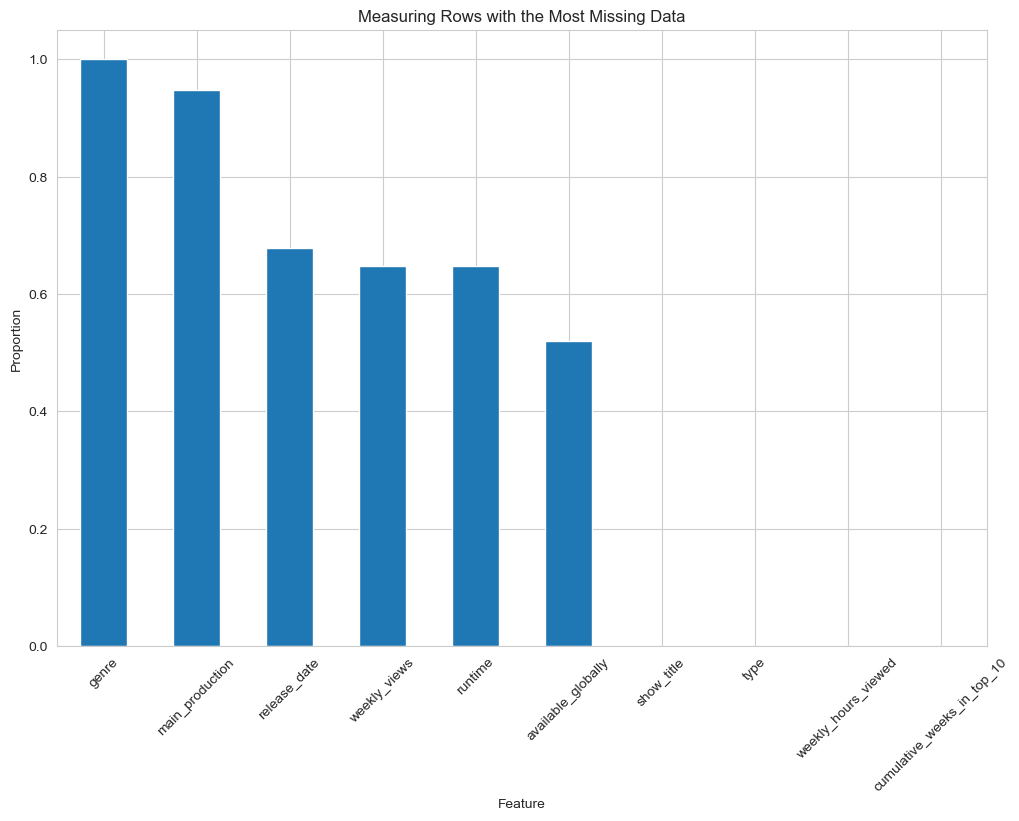

In [86]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [87]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,False,True,True,False,True,False
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,False,True,True,False,False,False
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,False,True,True,False,False,False
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,False,True,True,False,False,False
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,False,True,True,False,False,False
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,False,True,True,False,False,True
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,False,True,True,False,False,False
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,False,True,True,False,True,False


#### Dealing with Missing Data


In [88]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix.loc[netflix['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix.loc[netflix['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix['available_globally_Yes'] = netflix.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [89]:
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-04-03,False,False,True,True,False,True,True
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.066700,0.0,NaN,NaN,NaN,2023-08-27,False,False,True,True,False,False,True
2,10 Days of a Good Man,7.415000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2023-03-12,False,False,True,True,False,False,True
3,1000 Miles from Christmas,6.795000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-01-02,False,False,True,True,False,False,True
4,12 Strong,8.210000e+06,NaN,2,1.838932,0.0,NaN,NaN,NaN,2022-07-24,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.850000,0.0,NaN,NaN,NaN,2024-01-21,False,False,True,True,False,False,True
1861,¡Que viva México!,1.249250e+07,NaN,4,1.838932,0.0,2023-05-11,NaN,NaN,2023-06-04,False,False,True,True,False,False,True
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.933300,0.0,NaN,NaN,NaN,2023-10-22,False,False,True,True,False,False,True
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,1.838932,0.0,2022-01-20,NaN,NaN,2022-02-06,False,False,True,True,False,True,True


In [90]:
from sklearn.impute import SimpleImputer

In [91]:
Y=netflix[['weekly_hours_viewed', 'weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()

In [92]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
Y_imputed = imputer.fit_transform(Y)

pca = PCA(n_components=3)
Y_pca = pca.fit_transform(Y_imputed)


In [93]:
Y_completed = pca.inverse_transform(Y_pca)

In [97]:
Y_completed

array([[6.82500000e+06, 3.86786472e+06, 2.06809225e+00, ...,
        2.30300387e-01, 2.30525745e-01, 6.44715794e-01],
       [6.90000000e+06, 3.30000000e+06, 2.06252662e+00, ...,
        2.74518168e-01, 2.23226982e-01, 6.80113022e-01],
       [7.41500000e+06, 3.86786472e+06, 2.06810168e+00, ...,
        2.43440102e-01, 2.27070860e-01, 6.44183128e-01],
       ...,
       [4.95000000e+06, 2.55000000e+06, 2.05722338e+00, ...,
        2.87278011e-01, 2.25589583e-01, 7.28785549e-01],
       [2.91000000e+06, 3.86786472e+06, 3.04997091e+00, ...,
        1.40128166e-01, 2.55159452e-01, 6.82311769e-01],
       [5.46333333e+06, 3.86786472e+06, 3.05749189e+00, ...,
        1.96969975e-01, 2.40220817e-01, 6.80266030e-01]])

In [94]:
netflix = pd.DataFrame(Y_completed, columns=['weekly_hours_viewed', 'weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix.head()

,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,6825000.0,3.867865e+06,2.068092,2.423048,0.050743,0.003761,0.456861,0.543139,0.769700,0.230300,0.230526,0.644716
1,6900000.0,3.300000e+06,2.062527,2.592611,0.066840,0.005869,0.438188,0.561812,0.725482,0.274518,0.223227,0.680113
2,7415000.0,3.867865e+06,2.068102,2.480854,0.057153,0.003831,0.466361,0.533639,0.756560,0.243440,0.227071,0.644183
3,6795000.0,3.867865e+06,2.066275,2.420134,0.050393,0.003752,0.456469,0.543531,0.770362,0.229638,0.230698,0.644680
4,8210000.0,3.867865e+06,1.937978,2.560496,0.064046,0.003546,0.485696,0.514304,0.738459,0.261541,0.222189,0.638951


In [95]:
netflix['language_English'] = netflix['language_English'].round().astype(int)
netflix['language_Non-English'] = netflix['language_Non-English'].round().astype(int)
netflix['type_Films'] = netflix['type_Films'].round().astype(int)
netflix['type_TV'] = netflix['type_TV'].round().astype(int)
netflix['available_globally_No'] = netflix['available_globally_No'].round().astype(int)
netflix['available_globally_Yes'] = netflix['available_globally_Yes'].round().astype(int)

In [96]:
netflix

,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,6.825000e+06,3.867865e+06,2.068092,2.423048,0.050743,0.003761,0,1,1,0,0,1
1,6.900000e+06,3.300000e+06,2.062527,2.592611,0.066840,0.005869,0,1,1,0,0,1
2,7.415000e+06,3.867865e+06,2.068102,2.480854,0.057153,0.003831,0,1,1,0,0,1
3,6.795000e+06,3.867865e+06,2.066275,2.420134,0.050393,0.003752,0,1,1,0,0,1
4,8.210000e+06,3.867865e+06,1.937978,2.560496,0.064046,0.003546,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1860,2.400000e+06,1.300000e+06,1.055179,2.736313,0.058545,0.009842,0,1,1,0,0,1
1861,1.249250e+07,3.867865e+06,4.069879,2.951414,0.139132,0.010280,0,1,1,0,0,1
1862,4.950000e+06,2.550000e+06,2.057223,2.615772,0.065868,0.008415,0,1,1,0,0,1
1863,2.910000e+06,3.867865e+06,3.049971,2.026267,0.021367,0.006158,0,1,1,0,0,1
